# Zápočtový projekt - Mathematics in Finance

## Vojtěch Sekera

Some computation time estimates are given. As the test were run on a compact laptop, on an average device performance should not be an issue. The longest estimate is 60 seconds, for generation of 1000_000 random points.

#### Problem 1: Implement functions NPV and IRR.
Define two functions that compute the net present value (NPV) and the internal
rate of return (IRR). Similar functions are already implemented in the numpy library,
but your implementation should compute it directly and use the existing functions
only as a check for the correctness. The function NPV should be a function of (rate,
cash flow), the IRR should be a function of a (cash flow). Show that your function
replicates the numbers from the numpy documentation, namely
np.npv(0.281,[-100, 39, 59, 55, 20])
should give -0.00847859163845488 and
np.irr([-100, 39, 59, 55, 20])
should give 0.28094842115996066.

In [1]:
import numpy as np
from functools import reduce

def NPV(rate, cash_flow):
    #the cash flows are multiplied by the discount factor according to Horner scheme
    return reduce(lambda x, y: x/(1+rate) + y, reversed(cash_flow))

def IRR(cash_flow):
    #for Z_0, ..., Z_n muliply the whole equation from the definition of IRR by (1+r)^n, obviously (1+r) != 0 
    #then solve this polynomial in variable (1+r) and choose real roots
    roots = [np.real(x) for x in np.roots(cash_flow) if np.isreal(x) and x != 0]
    #then pick roots for which r > 0, that is iff (1 + r) > 1
    positive_roots = [x for x in roots if x > 1]
    if len(positive_roots)>0: return positive_roots.pop() - 1
    else: roots.pop() - 1

Our NPV, IRR functions are equal to the built in functions (in terms of rounding errors), their differences are negligible.

In [2]:
rate = 0.281
cash_flow = [-100, 39, 59, 55, 20]

abs(NPV(rate, cash_flow) - np.npv(rate, cash_flow))

<ipython-input-2-c4db5422aaa3>:4: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).
  abs(NPV(rate, cash_flow) - np.npv(rate, cash_flow))


1.865174681370263e-14

In [3]:
abs(IRR(cash_flow) - np.irr(cash_flow))

<ipython-input-3-86d439658864>:1: DeprecationWarning: numpy.irr is deprecated and will be removed from NumPy 1.20. Use numpy_financial.irr instead (https://pypi.org/project/numpy-financial/).
  abs(IRR(cash_flow) - np.irr(cash_flow))


1.3322676295501878e-15

#### Problem 2: Monte Carlo Simulation of Asset Prices.
Assume that the log returns of the asset price are independent and normally distributed with N(0, σ√
dt) distribution. Before the simulation, fix three parameters:
σ – the volatility of the asset, T – the sampling horizon, and n – the number of
sampling points. Make some reasonable choice for these parameters (like take the
SP500 volatility, consider daily returns over a few years). Let the increment dt be
T/n. It is helpful to store the sampling points in a numpy array time.

(a) Write the procedure that simulates n log increments with distribution
N(0, σ√dt), store them in a single object (you can call it logreturns), and plot it
on the corresponding time horizon [0, T].

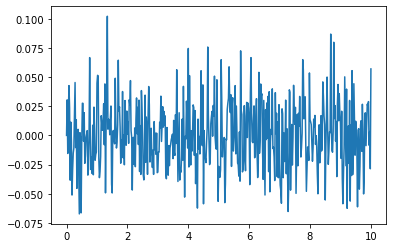

In [4]:
import numpy as np

sigma = 0.2
n = 500
T = 10
dt = T/n
time = np.linspace(0, T, num=n+1)

import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(31992195)

def log_inc(n):
    #this function generates normal distribution variates
    return np.append(0, stats.norm.rvs(size = n) * sigma * np.sqrt(dt))
logreturns = log_inc(n)

plt.plot(time, logreturns)
plt.show()
#this gives us "random" noise

(b) Take cumulative log returns and store it in an object cmlogret. Plot it in a
separate graph. Note that this is an instance of a random walk called Brownian
motion.

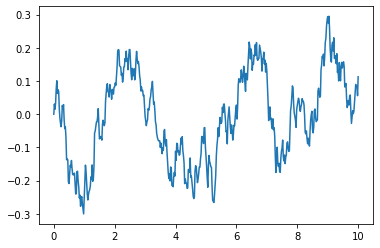

In [5]:
cmlogret = np.cumsum(logreturns)
plt.plot(time, cmlogret)
plt.show()
#random walk

(c) An instance of a simulated asset price should be an exponentiated cumulative
log return. More precisely, S(t) = S(0) · exp(cmlogret(t) − (1/2) · σ^2 · t).
Plot it on a separate graph.

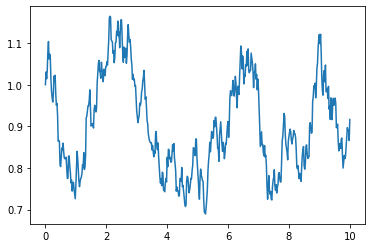

In [6]:
S0 = 1
S = S0 * np.exp(cmlogret- (sigma**2)*time/2)
plt.plot(time, S)
plt.show()

(d) Generate 20 scenarios of this price evolution and plot them on a single graph.

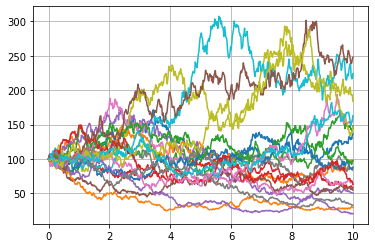

In [7]:
for i in range(20):
    plt.plot(time, 100*np.exp(np.cumsum(log_inc(n)) - (sigma**2)/2*time))
plt.grid()
plt.show()

#### Problem 3: Monte Carlo Simulation for Valuation.
Consider the following financial contract. The time horizon is T = 3 years and
there are n = 6 semiannual monitoring points. The contract has a face value 100.
The client receives 2.5% coupon when the monitoring price is above 80% of the
initial price of the underlying asset. This coupon is also received retroactively for all
monitoring points that were below 80% before any observed value above 80%. Thus
the number of 2.5% coupons received is in fact the index of the last observed value
above 80%. Moreover, if the price of the underlying security is above 100% at the
monitoring point, the contract is terminated (the coupons are paid). In addition,
if the price of the underlying asset is above 60% at the expiration time T = 3,
the client receives the face value 100 in full, otherwise she will receive the value
corresponding to the percentage of the final value of the underlying asset.

(a) Write the simulation procedure that computes the realized payoff for a single
asset evolution scenario.

In [8]:
import numpy as np

def MonteCarlo(sigma):
    n = 6
    T = 3
    dt = T/n
    time = np.linspace(0, T, num=n+1) # array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ])
    
    import scipy.stats as stats
    
    #this function generates normal distribution variates
    logreturns = stats.norm.rvs(size = n)*sigma*np.sqrt(dt)
    cmlogret = np.append(0, np.cumsum(logreturns))
    S = 100*np.exp(cmlogret - (sigma**2)*time/2)
    
    i = np.argmax(S)
    if S[i] > 100:
        return 100 + i*2.5
    else:  
        return (S[-1] + 2.5*np.max(np.where(S>=80)) if S[-1] < 60 else 100 + 2.5*np.max(np.where(S>=80))) 

(b) Generate sufficiently many scenarios that estimate the expected payoff of this
contract using the average payoff. Note the standard deviation of this result and
give 95% confidence interval of the expected payoff. Use some reasonable choices of
sigma (like 0.2 or 0.3). Try to find the value sigma for which the fair value of the
contract is at par.

From theory of probability, for quantil function $t$ 
$$ P_\mu(\overline{X}_n - t_{1-\frac{\alpha}{2}}\frac{S_{n}}{\sqrt{n}} < \mu < \overline{X}_n + t_{1-\frac{\alpha}{2}}\frac{S_{n}}{\sqrt{n}}) = 1 - \alpha, $$
Where $S_{n}^{2} = \sum(X_i - \overline{X})^2.$ For choices $\alpha = 0.05, \sigma = 0.2$ and $n=10000$ we get $S_n \approx 15.5$, thus
$$ P_\mu(\overline{X}_n - 1.96 \frac{15.5}{100} < \mu < \overline{X}_n + 1.96 \frac{15.5}{100}) = 0.95.$$
Which gives us estimation $|\mu - \overline{X}_n| \lessapprox 0.3038$ with confidence $95 \%$

In [9]:
def Generate(n, sigma):
    #np.random.seed()
    i = 0
    results = list()
    while i < n:
        results.append(MonteCarlo(sigma))
        i += 1
    return results

In [10]:
n = 50000 # this computation may take up to 20 seconds for n = 50000
sigma = 0.25
payoffs = Generate(n, sigma)
print('''For n = {} cases and sigma = {} we have the average payoff of {} 
and standard devitaion {}.'''.format(n, sigma, np.mean(payoffs), np.std(payoffs)))

For n = 50000 cases and sigma = 0.25 we have the average payoff of 102.13267513955634 
and standard devitaion 19.735928974659483.


In [11]:
# root binary search for an increasing function, finding zero point
def BinarySearch(a, b, function, depth):
    c = (a+b)/2
    
    if depth <= 0:
        return c
    
    print("At level {}, digging deeper...".format(depth))
    fc = function(c)    
    if fc >= 0: 
        return BinarySearch(a, c, function, depth-1)
    else:
        return BinarySearch(c, b, function, depth-1)

# Generate(..) is a decreasing function and we want it to equal 100
# for n >= 20000 and depth >= 5 this method seems to yield great results (~0.3 tolerance in av. payoff) 
n = 20000
sigma = BinarySearch(0.2, 0.3, lambda sigma: -(np.mean(Generate(n, sigma)) - 100) , 5)
# this may take a while

print("We found sigma = {}, whose value is pretty close to 100: (wait for it)".format(sigma))
print("Average payoff for this sigma is {}".format(np.mean(Generate(50000, sigma))))

At level 5, digging deeper...
At level 4, digging deeper...
At level 3, digging deeper...
At level 2, digging deeper...
At level 1, digging deeper...
We found sigma = 0.2828125, whose value is pretty close to 100: (wait for it)
Average payoff for this sigma is 100.13138068752528


(c) Plot the histogram of the payoff distribution for sigma 0.2 and 0.3.

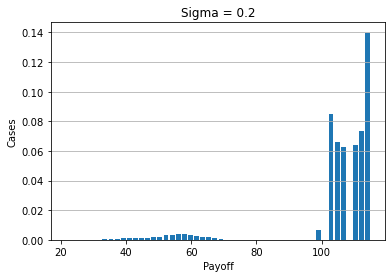

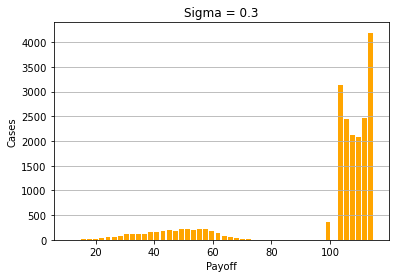

In [12]:
n = 20000

import matplotlib.pyplot as plt

sigma1 = 0.2
plt.figure(1)
plt.title("Sigma = {}".format(sigma1))
plt.hist(Generate(n, sigma1), density = True, rwidth = 0.8, bins = 50)
plt.grid(axis='y')
plt.xlabel("Payoff")
plt.ylabel("Cases")
plt.show()

sigma2 = 0.3
plt.figure(2)
plt.title("Sigma = {}".format(sigma2))
plt.hist(Generate(n, sigma2), rwidth = 0.8, bins = 50, color="orange")
plt.grid(axis='y')
plt.xlabel("Payoff")
plt.ylabel("Cases")
plt.show()

#### Problem 4: Optimal Mean Variance Portfolio.
The goal of this problem is to find the optimal portfolio weights for 10 randomly
chosen assets from SP500. First, download the table of components of SP500. 
(a) Compute the daily log returns of the prices and use these values to estimate the
annualized mean returns µ and the annualized covariance matrix Σ using the sample
mean and sample covariances. Make sure that the resulting covariance matrix is
positive definite.

(b) Find the optimal weights w with P10
i=1 wi = 1 that minimize the variance of
the resulting portfolio subject to the fixed constraint on the return of the portfolio.
Plot the resulting efficient frontier on the (x,y) = (standard deviation, mean) graph
together with the individual components that correspond to a point on this graph.

(c) Do the same with an additional restriction wi ≥ 0 for all i = {1, . . . , 10}.

In [13]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import time

table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = table['Symbol'].tolist()
np.random.seed(31992195)

mytickers = np.random.choice(tickers, 10, replace = False)
#['NOW', 'RCL', 'MSI', 'AVY', 'MTB', 'HLT', 'PKI', 'SYF', 'KHC', 'CME']

for i in range(len(mytickers)):
    mytickers[i] = mytickers[i].replace(".","-")

start_date = '2019-01-01'
end_date = time.strftime("%Y-%m-%d")
sp500 = data.DataReader(mytickers, 'yahoo', start_date, end_date)['Adj Close']

mytickers = list(mytickers)

# remove tickers which have "Nan" at the start date, i.e. aren't valid
for ticker in mytickers:
    if np.isnan(sp500[ticker]['2019-01-02']):
                del sp500[ticker]
                mytickers.remove(ticker) 
                
import re
print('Fetched. {} tickers are valid: {}.'.format(len(mytickers), re.sub('[\[\]\']', '', str(mytickers)) ) )

Fetched. 10 tickers are valid: NOW, RCL, MSI, AVY, MTB, HLT, PKI, SYF, KHC, CME.


Let $w = [w_1, ..., w_n]$ be the weight vector, $\sum{w_i} = 1$; $\Omega$ the covariance matrix. $\mu_p$ is the expected return: $\mu_p = w^{T}\mu$ where $\mu$ is the mean returns vector. $\sigma_{p}^2$ is the risk factor we want to minimize subject to $\mu_p$.
$$ \sigma_{p}^{2} = \frac{1}{2} w^T \Omega w \tag{1}$$

We have a Langrangian $L(\sigma_{p}^{2}; \sum{w_i} - 1, w^T \mu - \mu_p) $.

$$ \frac{\partial}{\partial w} \frac{1}{2}w^T \Omega w = \Omega w,\qquad  \frac{\partial}{\partial w} \sum{w_i} -1 = \mathbb{1}, \qquad \frac{\partial}{\partial w}w^{T}\mu - \mu_p= \mu$$

$$ \Omega w = \lambda_1 \mathbb{1} + \lambda_2 \mu$$

$$ w = \Omega^{-1}(\lambda_1\mathbb{1} + \lambda_2 \mu) \tag{2}$$

By multiplying by the $\mathbb{1}$ and $\mu$, respectively, from the left and using the equality constraints we get a system of linear equations, for $\quad\alpha=sum(\Omega^{-1}), \quad \beta = sum(\Omega^{-1}\mu),\quad \gamma = \mu^T\Omega^{-1}\mu $:

$$ 
\begin{eqnarray}
1 = \alpha\lambda_{1} + \beta\lambda_{2}, \\
\mu_p = \beta \lambda_1 + \gamma \lambda_2.
\end{eqnarray}
$$

The solution is $\lambda_1 = \frac{\gamma - \beta \mu_p}{\alpha \gamma - \beta^2}, \ \lambda_2 = \frac{\alpha \mu_p - \beta}{\alpha \gamma - \beta^2}$. We combine these and (1), (2) and use the fact that $\Omega^{-1}$ is symmetrical as is $\Omega$.

$$\sigma_{p}^{2} = \frac{1}{2}w^T \Omega w = w^T(\lambda_1\mathbb{1} + \lambda_2\mu) = (\lambda_1\mathbb{1} + \lambda_2\mu)^T\Omega^{-T}(\lambda_1\mathbb{1} + \lambda_2\mu) = (\lambda_1\mathbb{1} + \lambda_2\mu)^T\Omega^{-1}(\lambda_1\mathbb{1} + \lambda_2\mu) = 
\\
= \alpha\lambda_1^2 + 2\beta\lambda_1\lambda_2 + \gamma\lambda_2^2 = 
\lambda_1(\alpha + \beta\lambda_2) + \lambda_2(\beta\lambda_1 + \gamma) = \frac{\alpha \mu_{p}^{2} - 2\beta\mu_p + \gamma}{\alpha\gamma - \beta^2} = \frac{\alpha(\mu_{p} - \frac{\beta}{\alpha})^2 - \frac{\beta^2}{\alpha}  + \gamma}{\alpha\gamma - \beta^2}
$$ 

This gives us $\mu_p = \frac{\beta}{\alpha}$ with minimal risk factor $\sigma_{p}^2 = \frac{1}{\alpha}$. The weight vector can be expressed from (2).

In [14]:
n = len(mytickers) #this is the dimension of the problem, 
#this variable will be used throughout the whole solution

logreturns = np.log(1 + sp500.pct_change())

#to annualize the data
workdays = 250
mu = workdays*logreturns.mean()

#covariation matrix
omega = workdays*np.array(logreturns.cov().to_numpy())

pos = np.all(np.linalg.eigvals(omega) > 0)
print('Covariation matrix is ' + ('' if pos else 'not ') + 'positive definite.')

Covariation matrix is positive definite.


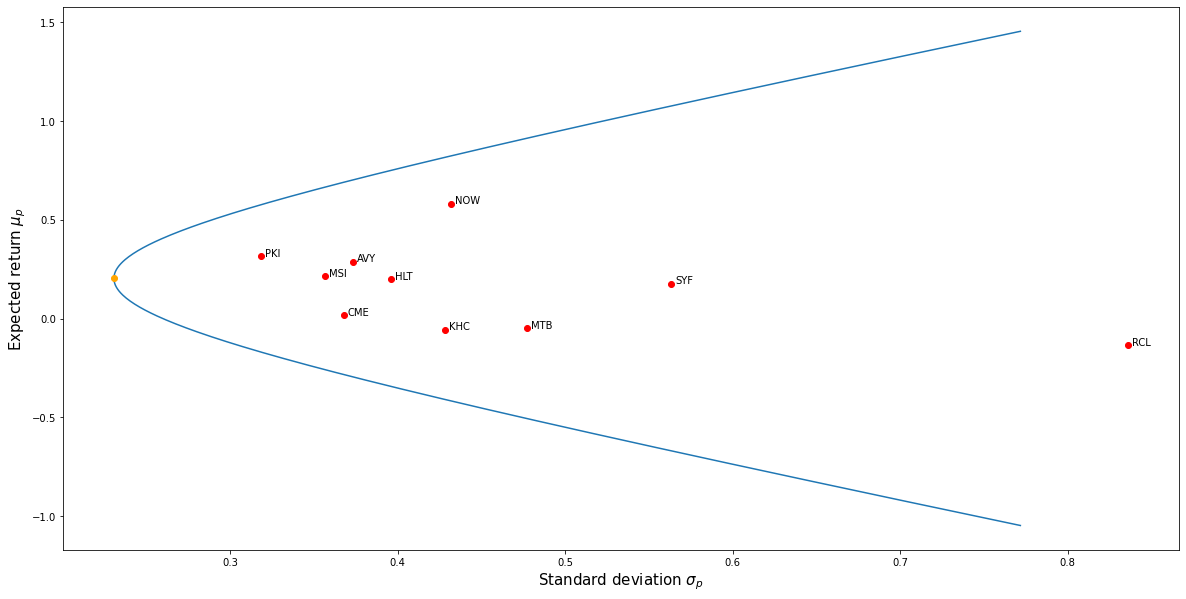

In [19]:
invomega = np.linalg.inv(omega)

ones = np.ones(n)

alpha = ones.dot(invomega.dot(ones))  
#np.sum(invcov) would give wrong results (probably because the matrix is not in a standard format)
beta = np.sum(invomega.dot(mu))
gamma = mu.dot(np.dot(invomega, mu))

mup = beta/alpha

#function sigma_p^2 with variable mu_p
def sigma(mup):
    return (alpha*mup**2 - 2*beta*mup + gamma)/(alpha*gamma - beta**2)

t = 0.005 * workdays
vect_count = 501

exp_return_grid = np.linspace(mup - t, mup + t, vect_count)
st_deviation = np.sqrt(sigma(exp_return_grid))

import matplotlib.pyplot as plt

plt.figure('minimalrisk', figsize = (20, 10))
plt.plot(st_deviation, exp_return_grid)
plt.plot(np.sqrt(1/alpha), mup, color='orange', marker = 'o')

def plot_tickers():
    for i in range(n):
        plt.plot(np.sqrt(omega[i,i]), mu[i], marker = 'o', color='red', label = mytickers[i])
        plt.text(np.sqrt(omega[i,i]) + 0.00015*np.sqrt(workdays), mu[i], mytickers[i])
    return

plot_tickers()

plt.xlabel("Standard deviation $\sigma_p$", size = 15)
plt.ylabel("Expected return $\mu_p$", size = 15)
plt.show()

In [20]:
def weight(mup):    
    return invomega.dot((gamma - beta*mup)*np.ones(n) + (alpha*mup - beta)*mu)/(alpha*gamma - beta**2)

w0 = weight(mup)
print('w_0 =')
for i in np.round(w0, 4):
    print(i)
print('sum(w_0) = {}'.format(sum(w0)))

w_0 =
0.0433
-0.1267
0.1745
0.0187
0.1023
0.4003
0.2797
-0.2251
0.1525
0.1804
sum(w_0) = 1.0


The plot of individual weights around the point $\mu_{p0}$ shows that for no value $\mu_p$ are all the weights non-negative. We need to take a different approach.

## Otrhogonal projection

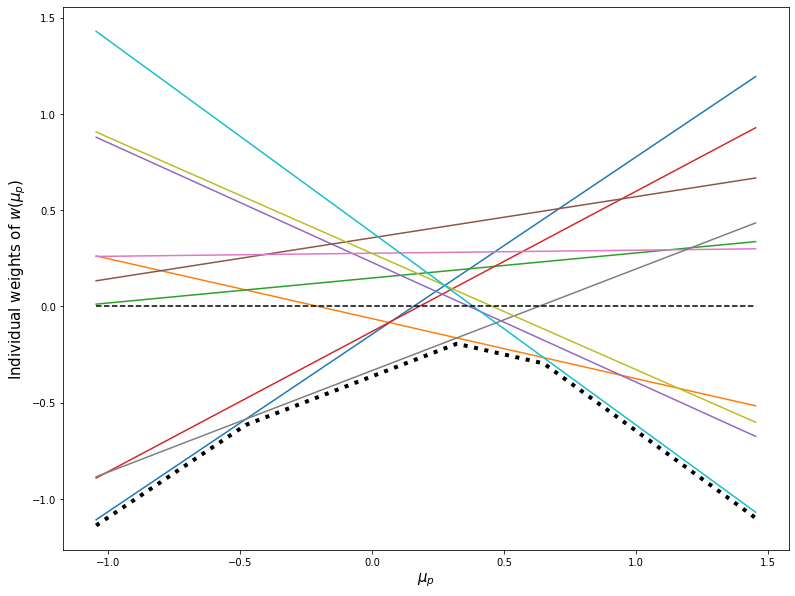

In [21]:
xw = [weight(a) for a in exp_return_grid]
 
plt.figure('vector weights', figsize = (13, 10))
plt.plot(exp_return_grid, xw)
plt.plot(exp_return_grid, vect_count*[0], color = 'black', ls = '--')
plt.plot(exp_return_grid, [min(vector) - 0.03 for vector in xw], color = 'black', ls = ':', linewidth=4)
plt.xlabel('$\mu_p$', size = 15)
plt.ylabel('Individual weights of $w(\mu_p)$', size = 15)
plt.show()

Since the solution is not to be found on the open set $\{w \in (0, \infty )^n \;|\; \sum w_i = 1\}$ it has to lie on the boundary $B = \{w \in [0, 1]^n \;|\; \sum w_i = 1\}$. For two dimensions this gives us just two points: $\begin{pmatrix} 1 & 0\end{pmatrix}$ and $\begin{pmatrix}0 & 1\end{pmatrix}$. For three dimensions, as shown in the picture below, we get line segments - the edges of the triangle. So it seemes that for n-dimensional space we have a (n-2)-dimensional set, which makes sense considering that a point lies on the boundary $B$ if and only if it has at least one coordinate equal to zero. Adding the condition of sum of the weights we see that (n-2) coordinates are (almost) free, one coordinate is equal to zero and the last is $1 -$ the other coordinates. 
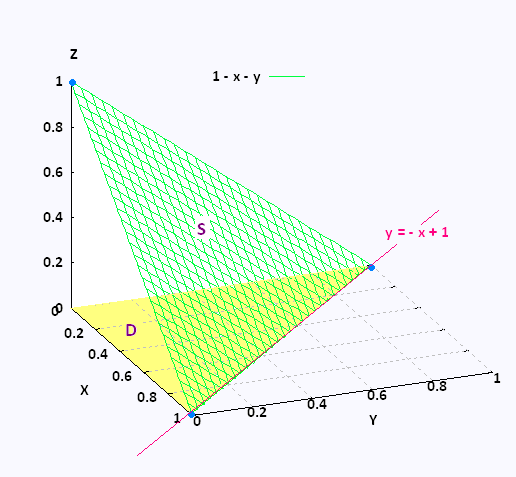
For our case, $n = 10$, we are dealing with some 8-dimensional mess. Look back at the triangle - what if we work with the affine plane it represents? Off course, we are adding an extra dimension, but the case is much simpler. The affine subspace is simply $\begin{pmatrix} 1 & 1 & ... & 1 \end{pmatrix}^*$ in dual coordinates, python does the other work. We will try to an orthogonal projection of vectors on the parabola from the solution without constraints. 

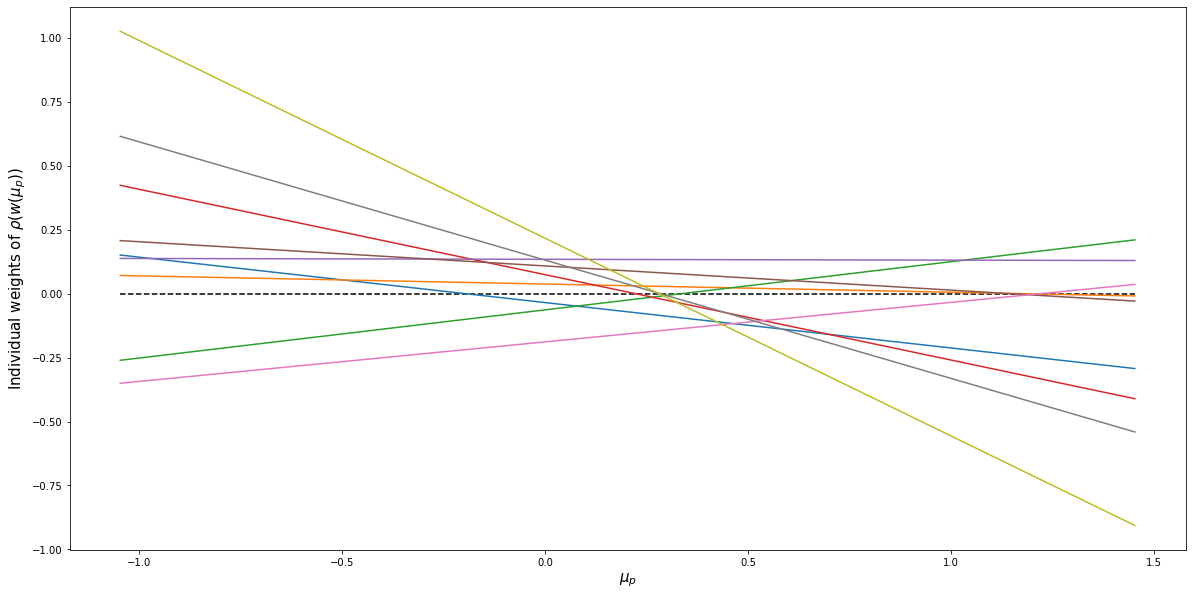

In [22]:
import numpy as np
from scipy.linalg import null_space 

ones = np.ones(n)
M = np.array([ones])

null_space = null_space(M)
base = null_space.T
for v in base:
    v /= np.linalg.norm(base)
# base * v = projection
projection = base.dot(np.array([v - ones/np.sqrt(n) for v in xw]).T)

plt.figure(figsize = (20, 10))
plt.plot(exp_return_grid, vect_count*[0], color = 'black', ls = '--')
plt.plot(exp_return_grid, projection.T)
plt.xlabel('$\mu_p$', size = 15)
plt.ylabel('Individual weights of $\\rho(w(\mu_p))$', size = 15)
plt.show()

No luck with projection. Lets try random points. One coordinate is equal to zero, others are random - but we still get close to zero in other coordinates.

### Generating random points

In [23]:
import numpy as np
import random 

indices = [i for i in range(n)]

def randomvector(zero_coordinates = 1):
    vector = np.zeros(n)
    for index in random.sample(indices, n - zero_coordinates):
        vector[index] = random.uniform(0, 1)
    return vector/np.sum(vector)  

def dev(v):
    return np.sqrt( v.dot( omega.dot(v) ))

<a id='random_points'></a>

In [24]:
# this will take just under a minute
points = 1000_000

vectors = list()
payoffs = list()
devias = list()

# we use the "while" statement, because "range()" is a generator rather than an iterator thus slower
i = 0
while i < points:
    vector = randomvector()
      
    vectors.append(vector)
    payoffs.append(np.dot(mu, vector))
    devias.append(dev(vector)) 
    
    i += 1

In [25]:
j = np.argmin(devias)
mindev, minpay, minvector = devias[j], payoffs[j], vectors[j]
print('We found a vector, whose sigma = {} is close to the minimal, as is shown on the upcoming plot'.format(mindev))

We found a vector, whose sigma = 0.2620547536370308 is close to the minimal, as is shown on the upcoming plot


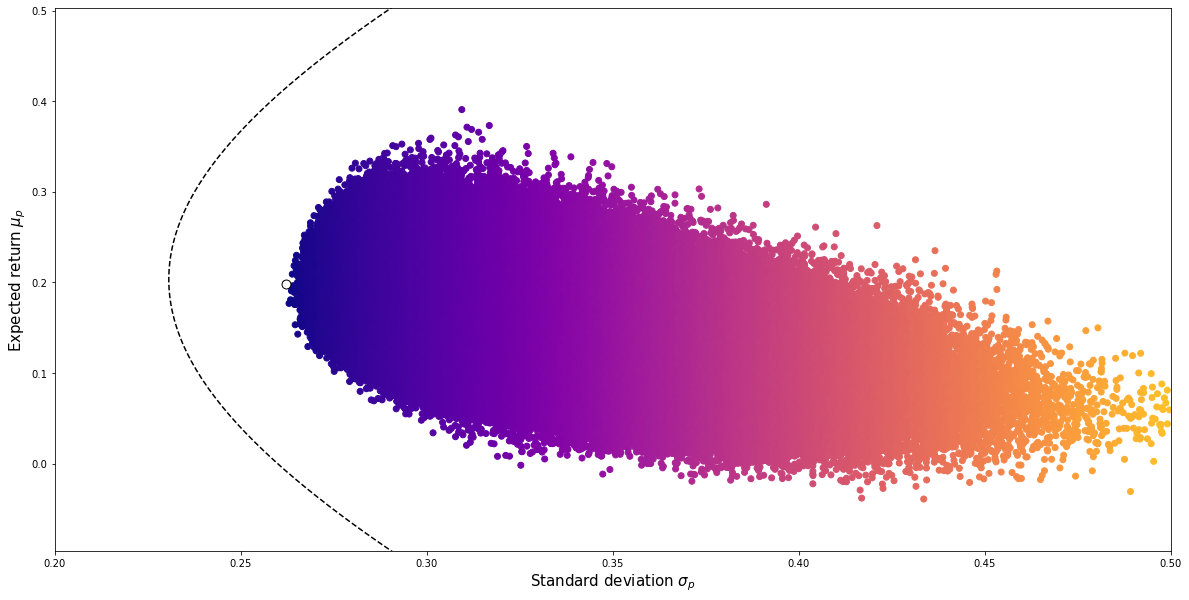

In [26]:
import matplotlib.pyplot as plt

plt.figure('minimalriskguess', figsize = (20, 10))

# plotting takes around 30 seconds
plt.scatter(devias, payoffs, c=devias , cmap='plasma')
plt.scatter(mindev, minpay, facecolors='white', edgecolors='black', marker = 'o', s = 80)

plt.plot(st_deviation, exp_return_grid, color = 'black', ls = '--')

plt.xlabel("Standard deviation $\sigma_p$", size = 15)
plt.ylabel("Expected return $\mu_p$", size = 15)

plt.gca().set_xlim([0.2, 0.5])
r = 0.3
plt.gca().set_ylim([mup - r, mup + r])
plt.show()

### Convergence to a local minimum
Our next idea is to take some vector that is close to some local minimum and to converge to the minimum. The computation time is really short (~ 5 seconds for  n = 200_000). We generate a perturbation from a generating set that we construct in a similar way to the edges of the triangle from the picture - one coordinate is 1 and some another is -1. The new vector, after adding the perturbation, has a high chance of not escaping the boundary. 

In [27]:
i, j = 0, 0
bond_v = list()
for i in range(n):
    for j in range(n):
        if i == j: continue
        v = np.zeros(n)
        v[i] = 1
        v[j] = -1
        bond_v.append(v)
    
bond_len = len(bond_v)
    
vectors2 = [minvector]
payoffs2 = [minpay]
devias2 = [mindev]    

points2 = 200_000
i = 0
while i < points2:    
    perturbation = bond_v[random.randint(0, bond_len-1)]*random.uniform(-1, 1)/(i+1) #the pert. has to decrease in some way 
    
    vector = vectors2[-1] + perturbation
    if np.sum(vector) != 1 or np.min(vector) != 0: 
        i += 1
        continue

    if  (deviation := dev(vector)) < (devias2[-1]):
        vectors2.append(vector)
        payoffs2.append(np.dot(mu, vector))
        devias2.append(deviation)
    i += 1

In [28]:
print('We converged to a new local minimum w, sigma(w) = {}.'.format(devias2[-1]))
print('w =')
for i in np.round(vectors2[-1], 4):
    print(i)

We converged to a new local minimum w, sigma(w) = 0.25976135514235466.
w =
0.0461
0.0
0.1314
0.0168
0.0
0.145
0.3447
0.0
0.1454
0.1706


Let's redraw the plot and take a closer look.

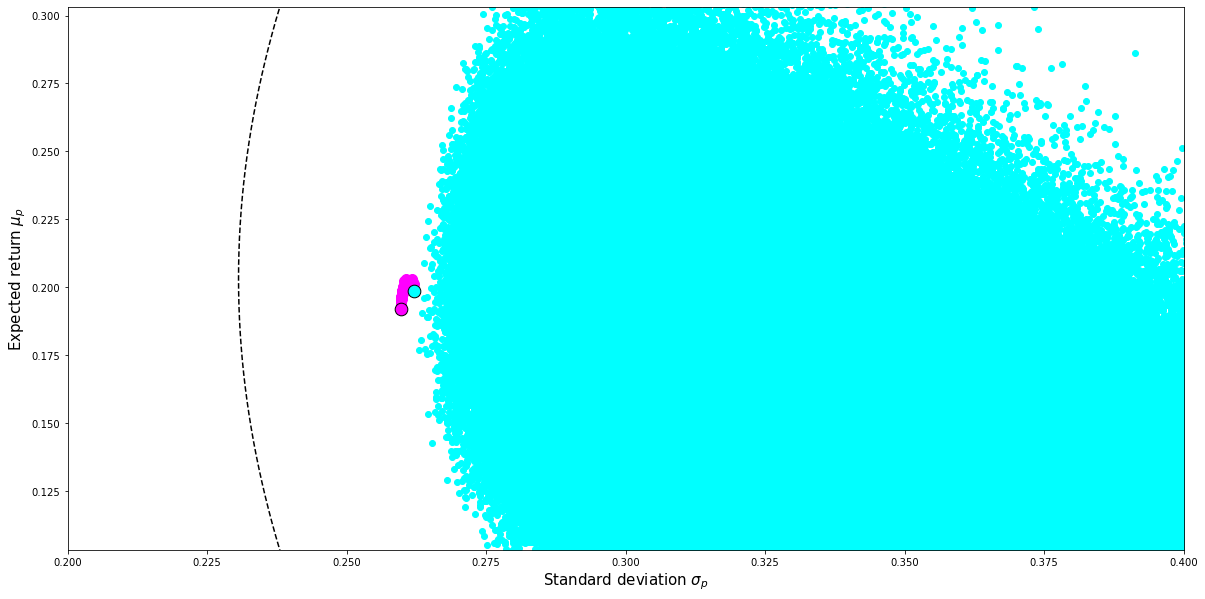

In [29]:
import matplotlib.pyplot as plt

plt.figure('minimalriskguess', figsize = (20, 10))
plt.scatter(devias, payoffs, color = 'cyan')

plt.scatter(devias2, payoffs2, color = 'magenta', s = 100)

plt.scatter(mindev, minpay, facecolors='cyan', edgecolors='black', s = 160)

plt.scatter(devias2[-1], payoffs2[-1], facecolors='magenta', edgecolors='black', s = 160)
plt.plot(st_deviation, exp_return_grid, color = 'black', ls = '--')


plt.xlabel("Standard deviation $\sigma_p$", size = 15)
plt.ylabel("Expected return $\mu_p$", size = 15)

plt.gca().set_xlim([0.2, 0.4])
r = 0.1
plt.gca().set_ylim([mup - r, mup + r])
plt.show()

The limit vector escaped well beyond the clutter of random points. Let's examine the convergence.

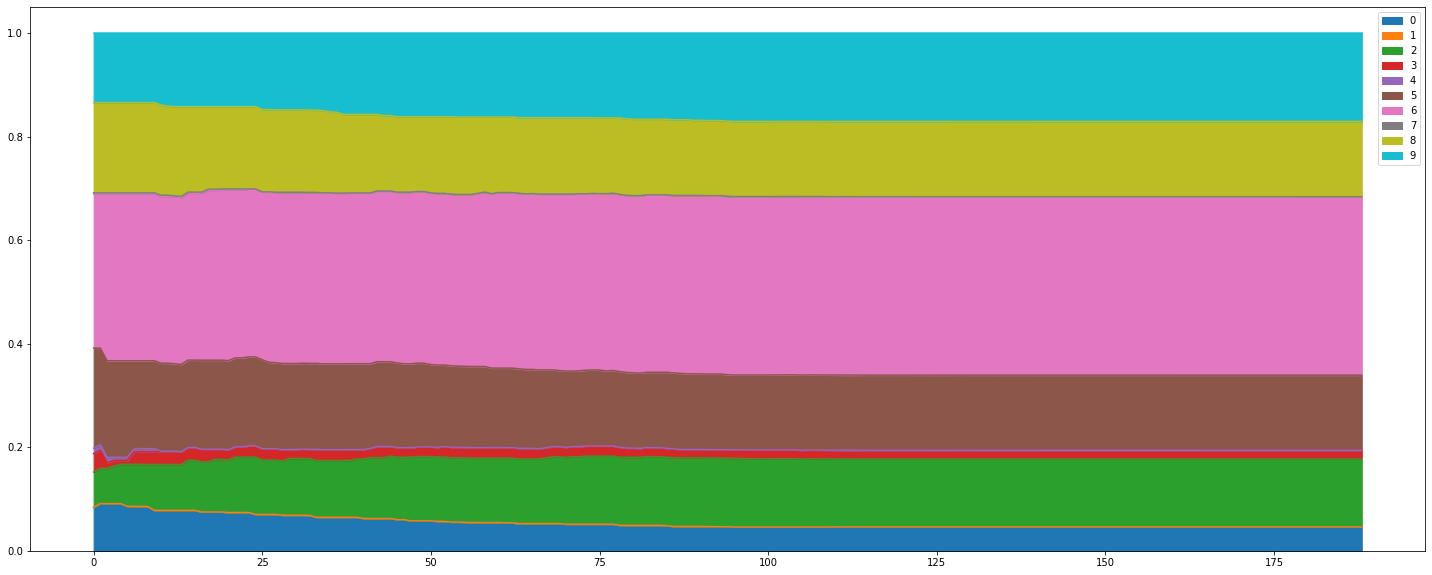

In [30]:
df = pd.DataFrame(vectors2)
df.plot.area(figsize = (25, 10))
plt.show()

We can see that the vector converged to a local minimum in a fast manner. To our surprise, it has three zero coordinates. This won't help us find the global minimum but at least we have a fabulous flag.

### Minimize function 

In [31]:
from scipy.optimize import minimize

def sigma2(x):
    return x.dot(omega.dot(x))
def weight_res(x):
    return sum(x)-1

def mean_res(mupp):
    def _m_res_(x):
        return np.dot(x, mu) - mupp
    return _m_res_

def nonneg_res(x):
        return min(x)

x_even = np.ones(n)/n 
#the initial guess  
    
def portfolio(mup1, x0 = x_even): 
    bnd = n*[(0,1)]
    con1 = {"type":"eq","fun": weight_res}
    con2 = {"type":"eq","fun": mean_res(mup1)}
    
    g = minimize(sigma2, x0, method="SLSQP", bounds = bnd, constraints = [con1, con2] )
    return g.x, g.fun

In [32]:
#exp_return_grid from previous plots
min_dev = list()
argmin_w = list()

#this takes around 5 seconds

for mup1 in exp_return_grid:
    min_weights, min_sigma = portfolio(mup1)
    min_dev.append(np.sqrt(min_sigma))
    argmin_w.append(min_weights)

In [33]:
j = np.argmin(min_dev)
min_w = argmin_w[j]
print('Sigma(w) = {}'.format(min_dev[j]))
print('w =')
for i in np.round(min_w, 4):
    print(i)
print('sum(w) =', sum(min_w))

Sigma(w) = 0.2597654745534478
w =
0.048
0.0
0.1292
0.0163
0.0
0.1471
0.3457
0.0
0.146
0.1677
sum(w) = 1.0


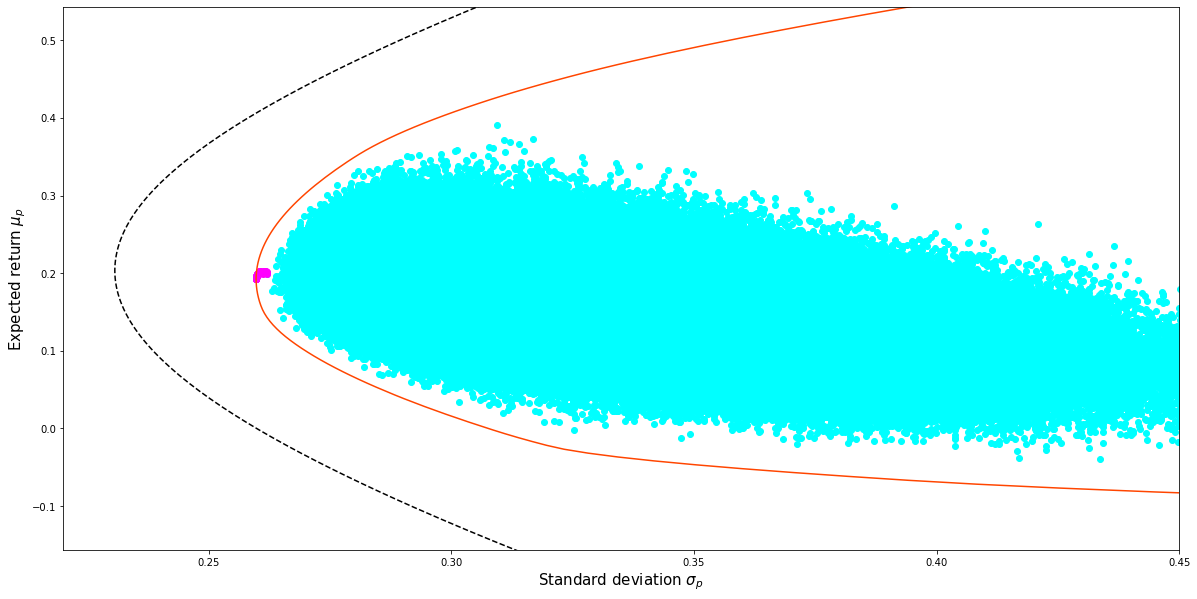

In [35]:
import matplotlib.pyplot as plt

plt.figure('minimalriskfinal', figsize = (20, 10))

plt.scatter(devias, payoffs, color = 'cyan')
plt.scatter(devias2, payoffs2, color = 'magenta')

plt.plot(st_deviation, exp_return_grid, color = 'black', ls = '--')
plt.plot(min_dev, exp_return_grid, color = 'OrangeRed')

plt.xlabel("Standard deviation $\sigma_p$", size = 15)
plt.ylabel("Expected return $\mu_p$", size = 15)

plt.gca().set_xlim([0.22, 0.45])
r = 0.35
mup_min = min_w.dot(mu)
plt.gca().set_ylim([mup_min - r, mup_min + r])
plt.show()

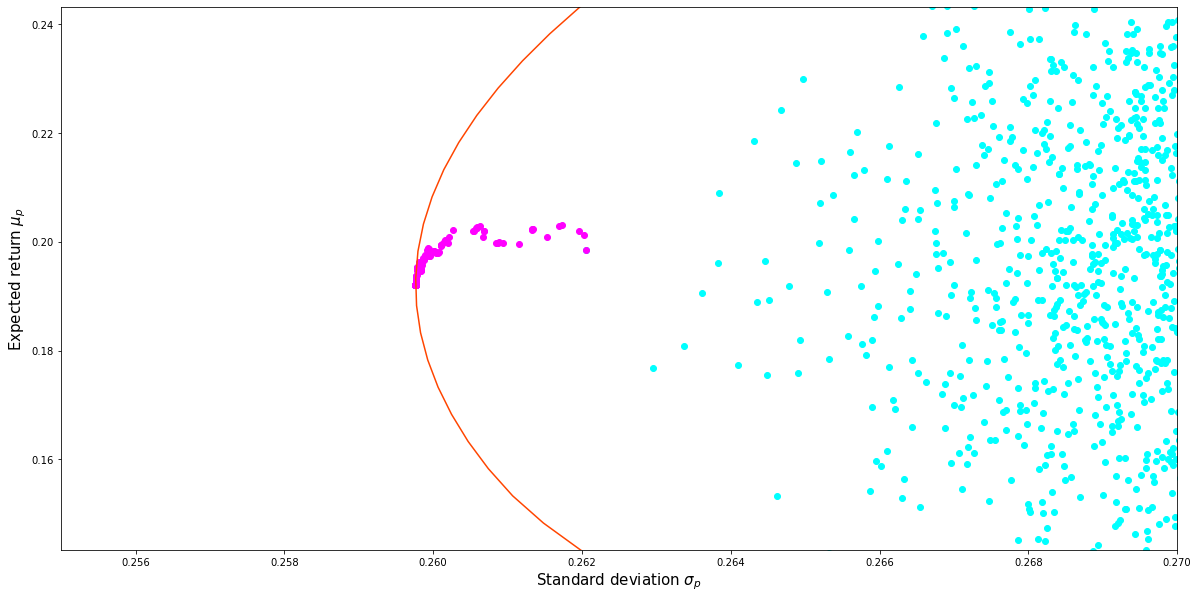

In [36]:
import matplotlib.pyplot as plt

plt.figure('minimalriskfinal', figsize = (20, 10))

plt.scatter(devias, payoffs, color = 'cyan')
plt.scatter(devias2, payoffs2, color = 'magenta')

plt.plot(st_deviation, exp_return_grid, color = 'black', ls = '--')
plt.plot(min_dev, exp_return_grid, color = 'OrangeRed')

plt.xlabel("Standard deviation $\sigma_p$", size = 15)
plt.ylabel("Expected return $\mu_p$", size = 15)

plt.gca().set_xlim([0.255, 0.27])
r = 0.05
mup_min = min_w.dot(mu)
plt.gca().set_ylim([mup_min - r, mup_min + r])
plt.show()

Our convergence wasn't that far off afterall.

In [37]:
print(('Difference between minimal sigmas from convergence and minimize function: ' 
       '{:.10f}'.format(np.round(min_dev[j] - devias2[-1], 10))))

Difference between minimal sigmas from convergence and minimize function: 0.0000041194


<b>Final remark</b>: We could have gotten a much better scatter plot using beta distribution. Redefine the randomvector() function and return to [Generating random points](#random_points).

In [ ]:
import numpy as np

indices = [i for i in range(n)]

def randomvector(zero_coordinates = 1):
    vector = np.random.beta(0.1, 4, n)
    for index in random.sample(indices, zero_coordinates):
        vector[index] = 0     
    return vector/np.sum(vector)